# Deep Learning Applications in Communications
By Jakob Hoydis, Stephan ten Brink, Sebastian Cammerer, and Sebastian D&ouml;rner.  
Contact [jakob.hoydis@nokia-bell-labs.com](mailto:jakob.hoydis@nokia-bell-labs.com), [cammerer@inue.uni-stuttgart.de](mailto:cammerer@inue.uni-stuttgart.de), [doerner@inue.uni-stuttgart.de](mailto:doerner@inue.uni-stuttgart.de)

This code is provided as supplementary material to the lecture course [Deep Learning Applications in Communications](https://www.inue.uni-stuttgart.de/teaching/dlacom/).    
It is licensed under the GPLv2 license. If you in any way use this code for research that results in publications, please cite it appropriately.

## Lecture 07: Autoencoders - Learning to communicate

*   Listeneintrag
*   Listeneintrag


### Training an end-to-end communications system on an AWGN channel

#### Import libraries

In [28]:
# magic command to use TF 1.X in colaboraty when importing tensorflow
#%tensorflow_version 1.x 
#import tensorflow as tf                       # imports the tensorflow library to the python kernel
#tf.logging.set_verbosity(tf.logging.ERROR)    # sets the amount of debug information from TF (INFO, WARNING, ERROR)
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 

print("Using tensorflow version:", tf.__version__)

Using tensorflow version: 2.5.0


In [29]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

#### System parameters

In [30]:
k = 3       # Number of information bits per message, i.e., M=2**k
n = 2       # Number of real channel uses per message
seed = 2    # Seed RNG reproduce identical results

#### The Autoencoder Class
In order to quickly experiment with different architecture and parameter choices, it is useful to create a Python class that has functions for training and inference. Each autoencoder instance has its own Tensorflow session and graph. Thus, you can have multiple instances running at the same time without interference between them.

In [31]:
class AE(object):
    def __init__(self, k, n, seed=None, filename=None):
        assert (n%2 == 0), "Channel only allows complex symbols -> n must be a multiple of 2"
        self.k = k 
        self.n = n
        self.n_complex = int(self.n/2)
        self.bits_per_symbol = self.k/self.n_complex
        self.M = 2**self.k
        self.seed = seed if (seed is not None) else int(time.time())           
        self.graph = None
        self.sess = None   
        self.vars = None
        self.saver = None   
        self.constellations = None
        self.blers = None
        self.create_graph()
        self.create_session()
        if filename is not None:    
            self.load(filename)       
        return
    
    def create_graph(self):
        '''This function creates the computation graph of the autoencoder'''
        self.graph = tf.Graph()        
        with self.graph.as_default():    
            tf.set_random_seed(self.seed)
            batch_size = tf.placeholder(tf.int32, shape=())
            
            # Transmitter
            s = tf.random_uniform(shape=[batch_size], minval=0, maxval=self.M, dtype=tf.int64)
            x = self.encoder(s)     
            
            # Channel
            noise_std = tf.placeholder(tf.float32, shape=())
            noise = tf.random_normal(tf.shape(x), mean=0.0, stddev=noise_std) 
            real_fade = tf.random.normal(shape=tf.shape(x))
            complex_fade = tf.random.normal(shape=tf.shape(x))
            fade = tf.complex(real_fade, complex_fade)
            fade = tf.math.abs(fade)
            fade = tf.math.sqrt(1/2)*fade
            y = x*fade + noise
           
            # Receiver
            s_hat = self.decoder(y)
            
            # Loss function
            cross_entropy = tf.losses.sparse_softmax_cross_entropy(labels=s, logits=s_hat)
                
            # Performance metrics
            correct_predictions = tf.equal(tf.argmax(tf.nn.softmax(s_hat), axis=1), s)
            accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
            bler = 1-accuracy
    
            # Optimizer
            lr = tf.placeholder(tf.float32, shape=()) # We can feed in any desired learning rate for each step     
            train_op = tf.train.AdamOptimizer(lr).minimize(cross_entropy)
        
            # References to graph variables we need to access later 
            self.vars = {
                'accuracy': accuracy,
                'batch_size': batch_size,
                'bler': bler,
                'cross_entropy': cross_entropy,
                'init': tf.global_variables_initializer(),
                'lr': lr,
                'noise_std': noise_std,
                'train_op': train_op,
                's': s,
                's_hat': s_hat,
                'x': x,
            }            
            self.saver = tf.train.Saver()
        return
    
    def create_session(self):
        '''Create a session for the autoencoder instance with the compuational graph'''
        self.sess = tf.Session(graph=self.graph)        
        self.sess.run(self.vars['init'])
        return
    
    def encoder(self, input):
        '''The transmitter'''
        W = self.weight_variable((self.M,self.M))    
        x = tf.nn.elu(tf.nn.embedding_lookup(W, input))
        x = tf.layers.dense(x, self.n, activation=None)
        x = tf.reshape(x, shape=[-1,self.n_complex,2])
        print(x);
        #Average power normalization
        x = x/tf.sqrt(2*tf.reduce_mean(tf.square(x))) 
        return x
    
    def decoder(self, input):
        '''The Receiver'''
        y = tf.reshape(input, shape=[-1,self.n])
        y = tf.layers.dense(y, self.M, activation=tf.nn.relu)
        y = tf.layers.dense(y, self.M, activation=None)
        print(y);
        return y
    
    def EbNo2Sigma(self, ebnodb):
        '''Convert Eb/No in dB to noise standard deviation'''
        ebno = 10**(ebnodb/10)
        return 1/np.sqrt(2*self.bits_per_symbol*ebno)
    
    def gen_feed_dict(self, batch_size, ebnodb, lr):
        '''Generate a feed dictionary for training and validation'''        
        return {
            self.vars['batch_size']: batch_size,
            self.vars['noise_std']: self.EbNo2Sigma(ebnodb),
            self.vars['lr']: lr,
        }    
    
    def load(self, filename):
        '''Load an pre_trained model'''
        return self.saver.restore(self.sess, filename)
        
    def plot_constellation(self, maxrange=None):
        '''Generate a plot of the current constellation'''
        x = self.transmit(range(self.M))
        if (maxrange is None):
            maxrange = np.max(np.abs(x))
        for k in range(self.n_complex):
            image = plt.figure(figsize=(6,6))
            plt.grid(True)
            plt.xlim(-maxrange,maxrange)
            plt.ylim(-maxrange,maxrange)
            for i in range(self.M):       
                plt.scatter(x[i,k,0],x[i,k,1],c="black",marker='x')   
            image.axes[0].set_xticks(np.array([-2,-1,0,1,2]))
            image.axes[0].set_yticks(np.array([-2,-1,0,1,2]))
            image.suptitle('%d. complex symbol' % (k+1))
            plt.xlabel('Re')
            plt.ylabel('Im')
        return x, image
    
    def save(self, filename):
        '''Save the current model'''
        return self.saver.save(self.sess, filename)  
    
    def test_step(self, batch_size, ebnodb):
        '''Compute the BLER over a single batch and Eb/No'''
        bler = self.sess.run(self.vars['bler'], feed_dict=self.gen_feed_dict(batch_size, ebnodb, lr=0))
        return bler
    
    def transmit(self, s):
        '''Returns the transmitted sigals corresponding to message indices'''
        return self.sess.run(self.vars['x'], feed_dict={self.vars['s']: s})
       
    def train(self, training_params, validation_params):  
        '''Training and validation loop'''
        for index, params in enumerate(training_params):            
            batch_size, lr, ebnodb, iterations = params            
            print('\nBatch Size: ' + str(batch_size) +
                  ', Learning Rate: ' + str(lr) +
                  ', EbNodB: ' + str(ebnodb) +
                  ', Iterations: ' + str(iterations))
            
            val_size, val_ebnodb, val_steps = validation_params[index]
            
            for i in range(iterations):
                self.train_step(batch_size, ebnodb, lr)    
                if (i%val_steps==0):
                    bler = self.sess.run(self.vars['bler'], feed_dict=self.gen_feed_dict(val_size, val_ebnodb, lr))
                    print(bler)                           
        return       
    
    def train_step(self, batch_size, ebnodb, lr):
        '''A single training step'''
        self.sess.run(self.vars['train_op'], feed_dict=self.gen_feed_dict(batch_size, ebnodb, lr))
        return 
    
    def weight_variable(self, shape):
        '''Xavier-initialized weights optimized for ReLU Activations'''
        (fan_in, fan_out) = shape
        low = np.sqrt(6.0/(fan_in + fan_out)) 
        high = -np.sqrt(6.0/(fan_in + fan_out))
        return tf.Variable(tf.random_uniform(shape, minval=low, maxval=high, dtype=tf.float32))
    
    def bler_sim(self, ebnodbs, batch_size, iterations):
        '''Monte Carlo simulations of BLER for a range of Eb/No
           Sometimes we to compute statistics for batch sizes that do not fit into the GPUs memory.
           You can average over multiple batches with small size instead.           
        '''
        BLER = np.zeros_like(ebnodbs)
        for i in range(iterations):
            bler = np.array([self.sess.run(self.vars['bler'],
                            feed_dict=self.gen_feed_dict(batch_size, ebnodb, lr=0)) for ebnodb in ebnodbs])
            BLER = BLER + bler/iterations
        return BLER
    
    def plot_bler(self, EbNodB, BLER):
        '''Plot a BLER curve'''
        image = plt.figure(figsize=(10,8))
        plt.plot(EbNodB, BLER, '-r', linewidth=2.0)
        plt.yscale('log')
        plt.xlabel('EbNo (dB)', fontsize=18)
        plt.ylabel('Block-error rate', fontsize=18)
        plt.grid(True)
        plt.ylim([1e-5,1])
        return image

## Training parameters

In [32]:
train_EbNodB = 7
val_EbNodB = train_EbNodB

training_params = [
    #batch_size, lr, ebnodb, iterations
    [100    , 0.001, train_EbNodB, 1000],
    [100    , 0.0001, train_EbNodB, 10000],
    [1000    , 0.0001, train_EbNodB, 10000]
]

validation_params = [
    #batch_size, ebnodb, val_steps 
    [100000, val_EbNodB, 10000],
    [100000, val_EbNodB, 10000],
    [100000, val_EbNodB, 10000]
]

## Create and train model

In [33]:
model_file = 'models/ae_k_{}_n_{}'.format(k,n)
ae = AE(k,n,seed)
ae.train(training_params, validation_params)
ae.save(model_file); # Save the trained autoencoder if you want to reuse it later

Tensor("Reshape:0", shape=(?, 1, 2), dtype=float32)
/home/neelabhro/.local/lib/python3.8/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/home/neelabhro/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1692: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
Tensor("dense_2/BiasAdd:0", shape=(?, 8), dtype=float32)

Batch Size: 100, Learning Rate: 0.001, EbNodB: 7, Iterations: 1000
0.88995

Batch Size: 100, Learning Rate: 0.0001, EbNodB: 7, Iterations: 10000
0.26617998

Batch Size: 1000, Learning Rate: 0.0001, EbNodB: 7, Iterations: 10000
0.21578997


## Evaluate trained model

In [34]:
ae = AE(k,n,seed, filename=model_file) #Load a pretrained model that you have saved if needed

Tensor("Reshape:0", shape=(?, 1, 2), dtype=float32)
Tensor("dense_2/BiasAdd:0", shape=(?, 8), dtype=float32)
INFO:tensorflow:Restoring parameters from models/ae_k_3_n_2


### Plot of learned constellations

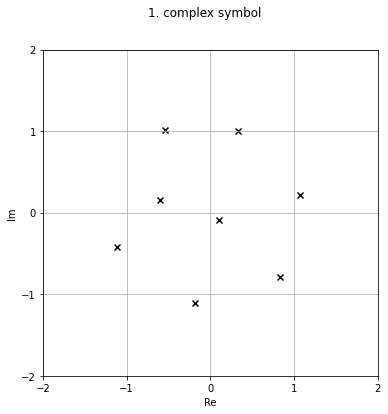

In [35]:
ae.plot_constellation();

### BLER Simulations

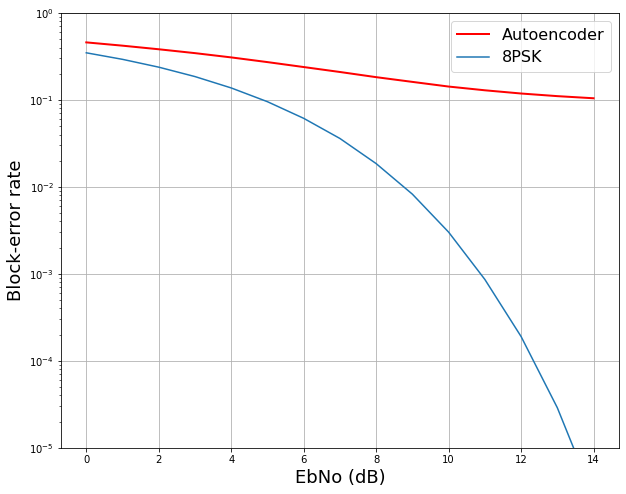

In [36]:
ebnodbs = np.linspace(0,14,15)
BLER_8PSK = [0.3478959, 0.2926128, 0.2378847, 0.1854187, 0.1372344, 0.0953536, 0.0614003, 0.0360195, 0.0185215, 0.0082433, 0.0030178, 0.0008626, 0.0001903, 0.0000289, 0.0000027, ]
blers = ae.bler_sim(ebnodbs, 1000000, 1);
ae.plot_bler(ebnodbs, blers);
plt.plot(ebnodbs,BLER_8PSK);
plt.legend(['Autoencoder', '8PSK'], prop={'size': 16}, loc='upper right');